# Is there any difference between the proportions of high-school regular smokers in British Columbia and Ontario?

In [1]:
library(tidyverse)
library(haven)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

Warning message:
“package ‘tidyr’ was built under R version 4.1.2”
Warning message:
“package ‘readr’ was built under R version 4.1.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



## Introduction

#### Why we're interested in the topic
Smoking becomes a common phenomenon among teenagers even though they know the negative effects of it. The prevalence of tobacco products makes it both more tempting to try and harder to quit for teenagers (Burton et al.). Scholars studying student smoking rates in ON (Reitsma and Manske) and BC (Johnson et al.) claim that the issue needs more attention as it causes severe health problems. Hence, our research analyses the problem by finding the **difference between the proportions of high-school regular smokers in British Columbia and Ontario**.

#### Our data set
We use the data obtained from a biennial school-based Health Canada's survey constructed in 2018/2019 that the studies smoking rates among Canadian students (Canada and Impact).

#### Variables
The variables we choose are aimed at defining our custom variable that determines whether a data set observation is a high-school student who is a regular smoker.

| Variable   	| Value   	| Meaning                                                 	|
|------------	|---------	|---------------------------------------------------------	|
| **GRADE**  	| [9, 12] 	| student is from a grade 9-12                            	|
| **DVRES**  	| 1 or 3  	| resident of Canada or has lived in Canada for 11+ years 	|
| **TS_011** 	| 1 or 2  	| will smoke a cigarette within next year                 	|
| **TV_010** 	| 1 or 2  	| will use an e-cigarette within next year                	|
| **SS_040** 	| 1       	| has smoked 100+ cigarettes                              	|
| **SS_060** 	| 7 or 8  	| has smoked 20-30 cigarettes during the last 30 days     	|
| **WP_030** 	| 3 or 6  	| has smoked every day in the past week                   	|

## Methods

#### Why our research is reliable
* Data is from 2018-2019, so it is timely
* Data set has many variables, so we can precisely define our "regular smoker" variable

#### Calculation procedures for the final report
We're conducting a hypothesis test of the difference between the proportions of high-school smoking students in BC and ON. Here's an outline:
* Find point estimate
* Use bootstrapping to create sampling distribution
* Conduct hypothesis test using p-value
    * Plot the bootstrap distribution with the p-value
    * Decide on the rejection of H<sub>0</sub>
* Conduct hypothesis test using CI
    * Plot the bootstrap distribution with the CI endpoints
* Compare the results of the p-value and CI approaches
    
Below we calculate the point estimate, i.e., we do the first step in the plan.

## Preliminary Results

#### Reading the data

In [2]:
data <- read_sav("https://abacus.library.ubc.ca/api/access/datafile/95464?format=original&gbrecs=true")
data %>%
  head()

SCANID,MODULE,PROVID,SCHID,GRADE,SEX,SS_010,SS_020,TS_011,TV_010,⋯,DVTY2ST,DVLAST30,DVAMTSMK,DVCIGWK,DVNDSMK,DVAVCIGD,DVRES,DVURBAN,DVHHINC2,WTPP
<dbl>,<dbl+lbl>,<dbl+lbl>,<dbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,⋯,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl>,<dbl>
100224,1,35,3589267,9,1,1,13,2,3,⋯,1,1,1,8,5,2,1,2,60000,33.15
100225,1,35,3589267,9,1,1,13,1,1,⋯,1,1,10,70,7,10,1,2,60000,33.15
100226,1,35,3589267,12,1,2,NA,4,3,⋯,7,2,NA,NA,NA,NA,3,2,60000,75.14
100227,1,35,3589267,12,2,1,NA,3,2,⋯,4,1,0,0,0,0,1,2,60000,105.70
100228,1,35,3589267,12,1,1,NA,3,3,⋯,6,2,NA,NA,NA,NA,1,2,60000,75.14
100229,1,35,3589267,11,1,2,NA,4,3,⋯,7,2,NA,NA,NA,NA,1,2,60000,63.87


#### Exploratory analysis

Next, we filter the data by `GRADE` and introduce a new categorical variable `regular_smoker` that takes values `yes` or `no`. This variable is derived from the "regular smoker" definition stated above, and it represents whether a student smokes regularly.

In [3]:
all_provinces <- data %>%
  filter(GRADE %in% 9:12) %>%
  mutate(regular_smoker = if_else(
    ((DVRES == 1 | DVRES == 3) &
      (TS_011 %in% 1:2) &
      (TV_010 %in% 1:2) &
      (SS_040 == 1) &
      (SS_060 %in% 7:8) &
      (WP_030 == 3 | WP_030 == 6)),
    "yes", "no"
  )) %>%
  filter(!is.na(regular_smoker)) %>%
  mutate(province = as_factor(PROVID),
         grade = as_factor(GRADE)) %>%
  arrange(province) %>%
  select(province, grade, regular_smoker)

all_provinces %>%
  tail(3)

province,grade,regular_smoker
<fct>,<fct>,<chr>
British Columbia,Grade 10,no
British Columbia,Grade 10,no
British Columbia,Grade 10,no


Now we plot `all_provinces` data frame.

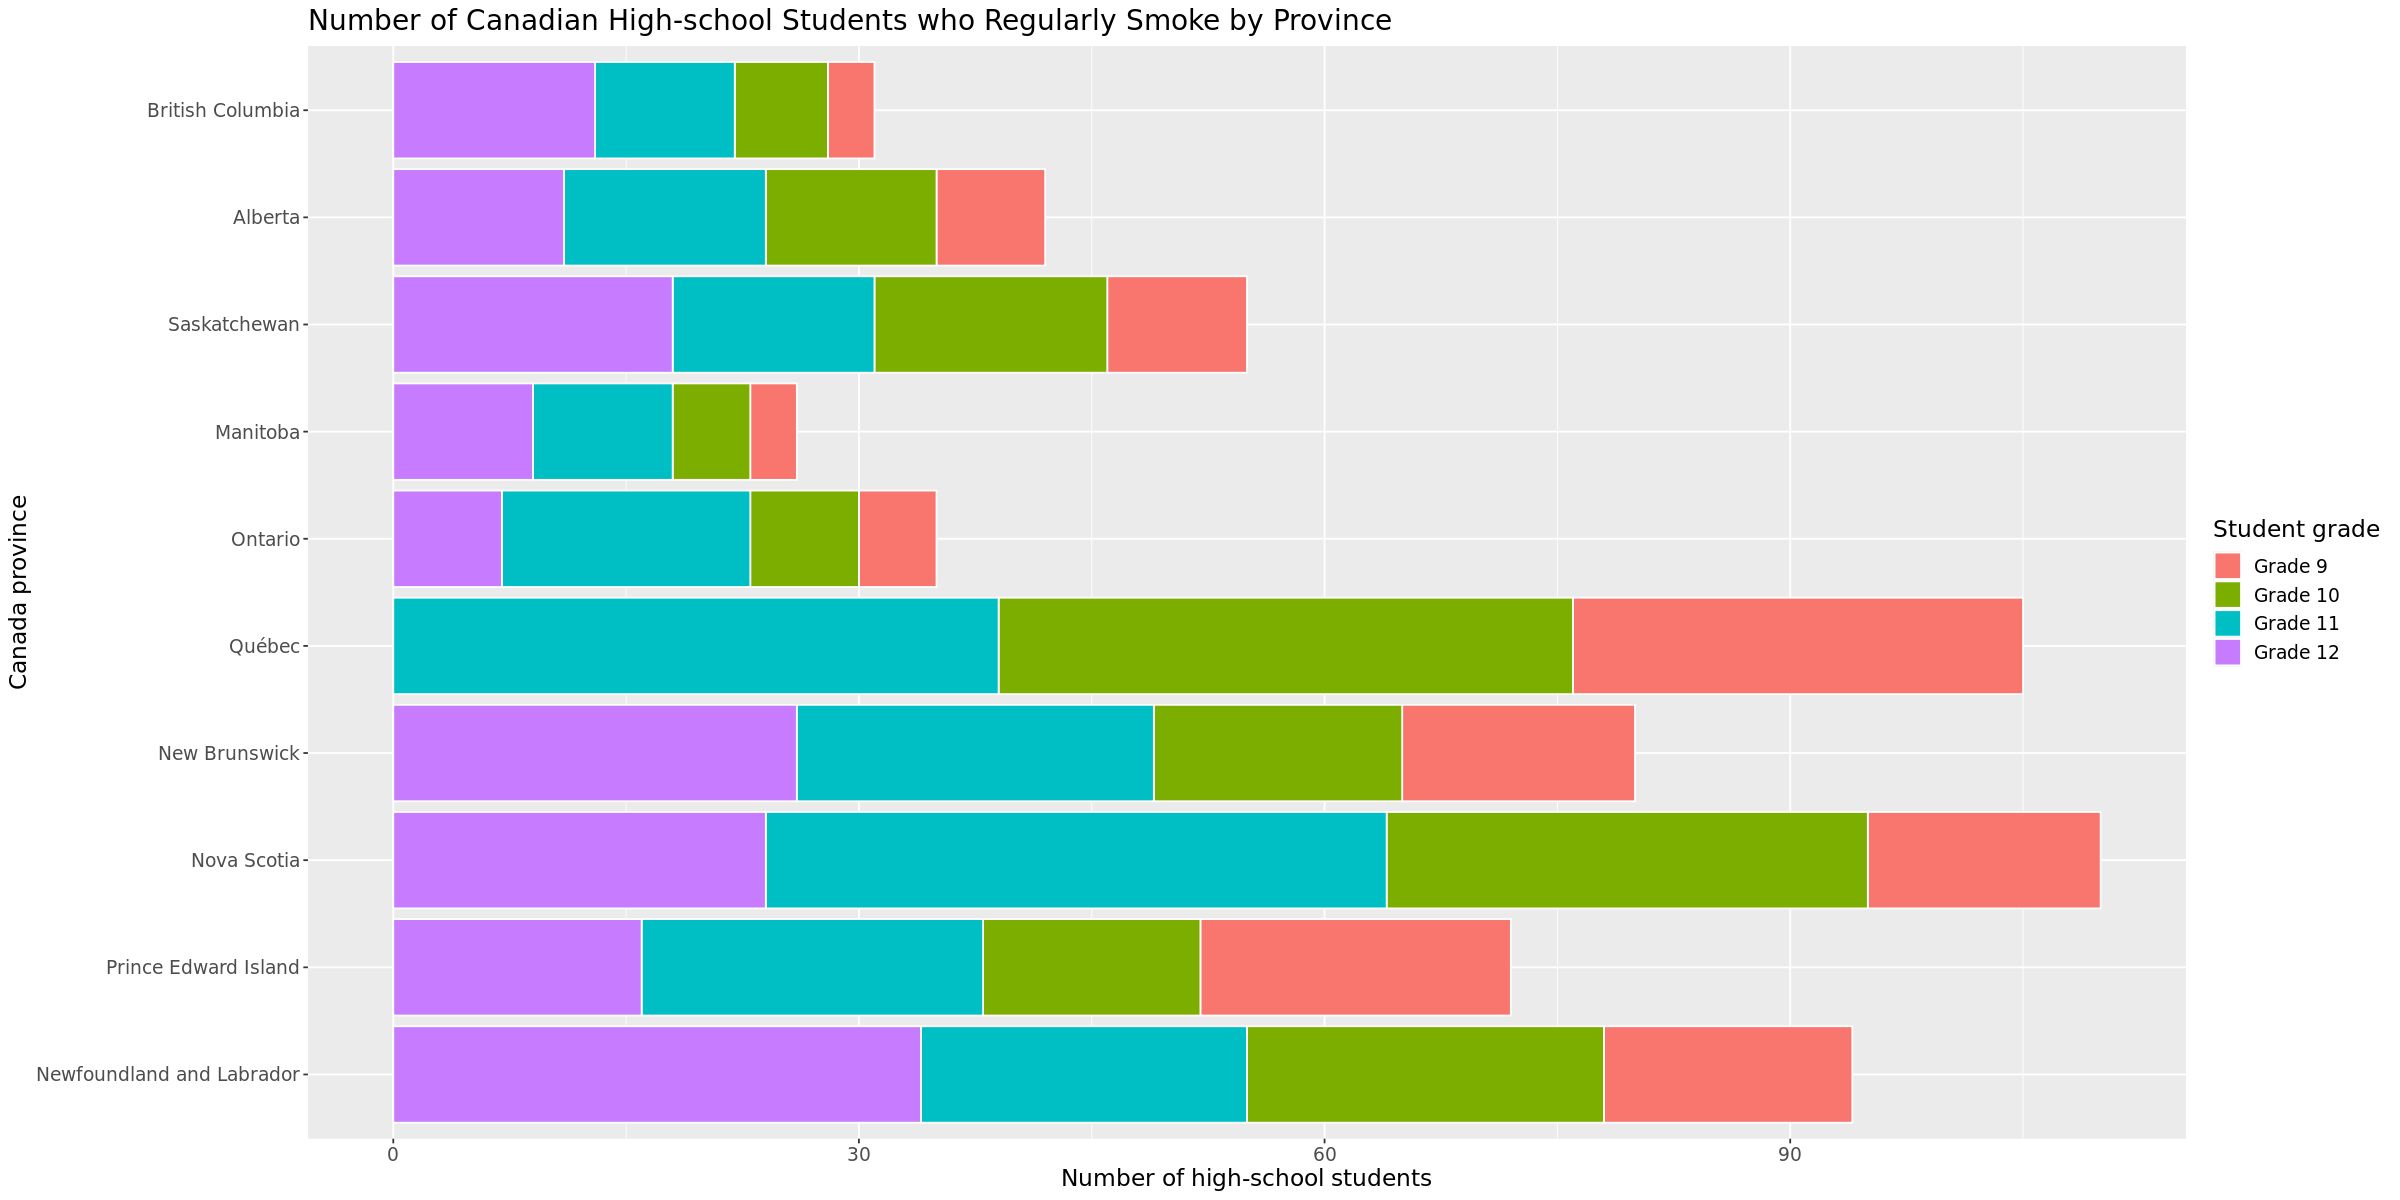

In [4]:
options(repr.plot.width = 20, repr.plot.height = 10)

all_provinces %>%
  filter(regular_smoker == "yes") %>%
  ggplot(aes(x = province, fill = grade)) +
  geom_bar(color = "white") +
  labs(title = "Number of Canadian High-school Students who Regularly Smoke by Province",
       x = "Canada province",
       y = "Number of high-school students",
       fill = "Student grade") +
  coord_flip() +
  theme(text = element_text(size = 14))

The bar chart shows that BC and ON have a small number of smoking high-school students comparing to other regions and that those students are from all all high-school grades.

Since the numbers of regular smokers in the provinces of interest are approximately same, our point estimate is going to be close to 0.

#### Point estimate calculation

Now we include the `province` in our filtering procedure and remove the `grade` column.

In [5]:
sample <- all_provinces %>%
  filter(province == "British Columbia" | province == "Ontario") %>%
  select(province, regular_smoker)

sample %>%
  distinct()

province,regular_smoker
<fct>,<chr>
Ontario,no
Ontario,yes
British Columbia,no
British Columbia,yes


Then, we group our data set by the `province` variable and find the proportions.

In [6]:
sample_proportions <- sample %>%
  group_by(province) %>%
  summarise(prop = mean(regular_smoker == "yes"))
sample_proportions

province,prop
<fct>,<dbl>
Ontario,0.012477718
British Columbia,0.007082477


We subtract **the BC proportion from the ON proportion**, and it gives us the point estimate.

In [7]:
point_estimate <- 
  sample_proportions$prop[1] - sample_proportions$prop[2]

point_estimate

[1] 0.005395242

## Evaluation

#### Why further analysis is required
The point estimate found above tells that there is a difference in the proportions. However, this point estimate doesn't take into consideration the standard error associated with it, so further analysis using hypothesis testing and CI techniques is required.

#### Expectations
We expect the true proportion difference to be a small value because our graph above and the point estimate show that there's a little difference between the sample proportions.

#### Future questions
Others can extend our research question by comparing the proportion of high-school smoking students between other Canadian provinces.

## References
Burton, Suzan, et al. “‘Smoking Is Bad, It’s Not Cool…yet
I’m Still Doing It’: Cues for Tobacco Consumption in a ‘Dark’ Market.” *Journal
of Business Research*, vol. 68, no. 10, 1 Oct. 2015, pp. 2067–2074,
www.sciencedirect.com/science/article/pii/S0148296315001186, 10.1016/j.jbusres.2015.03.004.
Accessed 14 Dec. 2021.

Canada, Health, and PROPEL Centre for Population Health
Impact. “2018/2019 Canadian Student Tobacco, Alcohol and Drugs Survey.” *Abacus.library.ubc.ca*,
18 Nov. 2020, abacus.library.ubc.ca/dataset.xhtml?persistentId=hdl:11272.1/AB2/WEFOHY.
Accessed 1 Mar. 2022.

Johnson, Joy L., et al. “Socio-Demographic Correlates of
Cigarette Smoking among High School Students.” *Canadian Journal of Public
Health*, vol. 95, no. 4, July 2004, pp. 268–271, 10.1007/bf03405129.
Accessed 5 May 2020.

Reitsma, Angela H., and Steve Manske. “Smoking in Ontario
Schools.” *Canadian Journal of Public Health*, vol. 95, no. 3, May 2004,
pp. 214–218, 10.1007/bf03403652. Accessed 29 Oct. 2019.

**Word Count: 488**